# Problem Statement:
### Formula 1 is a sport most widely viewed in Europe. This project seeks to explore ways in which Formula 1 can efficiently market itself to viewers outside of Europe using text data from the Formula 1 and Nascar subreddits. Specifically, we will try and find ways of marketing towards Nascar viewers given that they have already demonstrated an interest in motorsports and should be an easier population to convert to Formula 1. Multinomial Naive Bayes and random forest classification will be used to answer this question.

In [68]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [69]:
# reading in the webscraped data
df = pd.read_csv('reddit_data.csv')

In [70]:
df.head(3)

,subreddit,selftext,title
0,NASCAR,NaN,Using this website http://www.paintschemes.ca/...
1,NASCAR,Welcome to this week's Forgotten Rides Friday!...,"Forgotten Rides Friday - November 27, 2020"
2,NASCAR,Everytime I bring up the errors of the playoff...,"Turns out, hypothetically, under the current p..."


### Data exploration

In [71]:
# checking for null values
df.isnull().sum()

subreddit       0
selftext     1204
title           0
dtype: int64

In [72]:
# summary stats and checking for duplicates
df.describe()

,subreddit,selftext,title
count,2000,796,2000
unique,2,530,1917
top,formula1,[removed],Infrared photocell sensors is very excellent a...
freq,1000,153,24


In [73]:
# dropping duplicate posts
df = df.drop_duplicates()

Since most posts in both r/nascar and r/formula1 are images I will only be looking at the titles of the posts

In [74]:
# splitting the data into dependent and independent variables.
X = df['title']
y = df['subreddit']
# only looking at titles

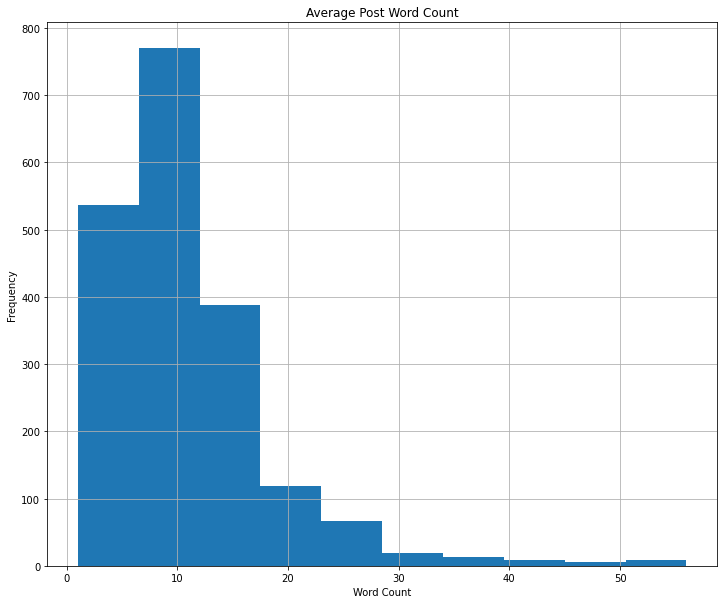

In [161]:
# finding average word count of title posts
plt.figure(figsize=(12,10))
plt.title("Average Post Word Count")
plt.xlabel('Word Count')
plt.ylabel('Frequency')
X.str.split().map(lambda x: len(x)).hist() # splitting title by word then getting the length of each post

Interpretation: Title word count is right skewed with most titles being about 10 words. No major outliers.

In [82]:
# longest title is 56 words. Reddit titles cannot exceed 150 words.
sorted(X.str.split().map(lambda x: len(x)))[-1]

56

Vecorizing text data for further data exploration

In [83]:
cvec = CountVectorizer(max_features=10_000, ngram_range=(1,2))
cvec.fit(X)
X_cvec1 = cvec.transform(X)

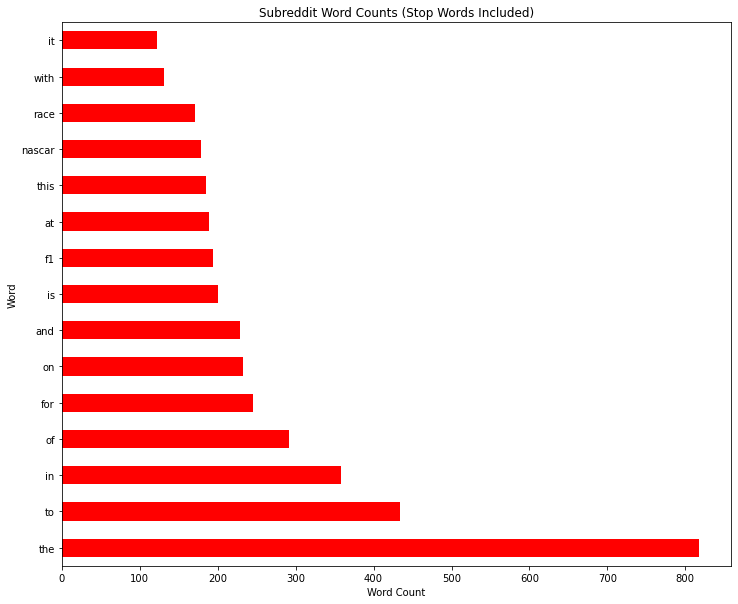

In [162]:
# plotting most common words in data set (not using stopwords)
plt.figure(figsize=(12,10))
plt.title("Subreddit Word Counts (Stop Words Included)")
plt.xlabel('Word Count')
plt.ylabel('Word')
X_df = pd.DataFrame(X_cvec1.todense(), 
                          columns=cvec.get_feature_names())
X_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', color = 'red');

Interpretation: Considering the most common words are not markers we can use for marketing we will want to use stopwords

In [85]:
# adding stop words to count vectorization
cvec_2 = CountVectorizer(max_features=10_000, ngram_range=(1,2), stop_words='english')
cvec_2.fit(X)
X_cvec2 = cvec_2.transform(X)

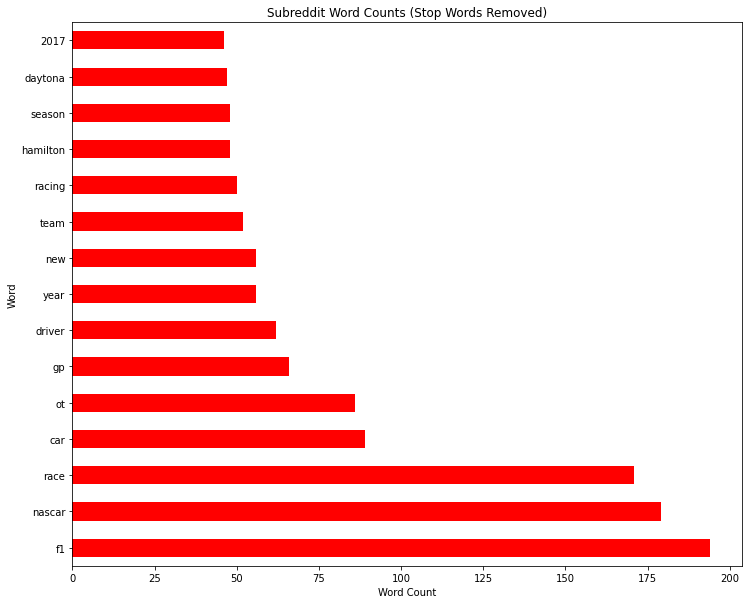

In [163]:
# creating a bar chart for most common words in dataframe excluding english stopwords
plt.figure(figsize=(12,10))
plt.title("Subreddit Word Counts (Stop Words Removed)")
plt.xlabel('Word Count')
plt.ylabel('Word')
X_df_2 = pd.DataFrame(X_cvec2.todense(), 
                          columns=cvec_2.get_feature_names())
X_df_2.sum().sort_values(ascending=False).head(15).plot(kind='barh', color = 'red');

Interpretation: We can now better see words that may be worth marketing to although words like nascar and f1 do not provide
    important information so they should be removed also

In [87]:
# creating lists for additional stopwords that should be excluded from analysis
nascar_driver_list = ['Aric', 'Almirola', 'Christopher', 'Bell', 'Ryan', 'Blaney', 'Alex', 'Bowman', 'Clint', 'Bowyer', 'Chris', 'Buescher', 'Kurt', 'Busch', 'Kyle', 'Busch', 'William', 'Byron', 'Cole', 'Custer', 'Matt', 'DiBenedetto', 'Austin', 'Dillon', 'Ty', 'Dillon', 'Chase', 'Elliott', 'Joey', 'Gase', 'Denny', 'Hamlin','Kevin', 'Harvick', 'Quin', 'Houff', 'Jimmie', 'Johnson','Erik', 'Jones', 'Brad', 'Keselowski', 'Corey', 'LaJoie', 'Matt', 'Kenseth', 'Joey', 'Logano', 'Michael', 'McDowell', 'John', 'Hunter', 'Nemechek', 'Ryan', 'Newman', 'Brennan', 'Poole','Ryan', 'Preece', 'Tyler', 'Reddick', 'Ricky', 'Stenhouse', 'Jr', 'Daniel', 'Suarez', 'Martin', 'Truex', 'Bubba', 'Wallace', 'J. J.', 'Yeley', 'Jeff', 'Gordon', 'Carl', 'Edwards','Dale', 'Earnhardt', 'Jamie', 'Mcmurray']
f1_driver_list = ['Lewis', 'Hamilton', 'Valtteri', 'Bottas', 'Charles', 'Leclerc', 'Sebastian', 'Vettel', 'Max', 'Verstappen','Alex', 'Albon', 'Carlos', 'Sainz','Lando', 'Norris', 'Daniel', 'Ricciardo','Esteban', 'Ocon', 'Pierre', 'Gasly','Daniil', 'Kvyat','Sergio', 'Perez','Lance', 'Stroll','Kimi', 'Raikkonen','Antonio', 'Giovinazzi','Kevin', 'Magnussen', 'Romain', 'Grosjean', 'George', 'Russell','Nicholas', 'Latifi', 'Nico', 'Keke', 'Rosberg', 'Michael', 'Schumacher', 'Mike', 'Hawthorn', 'Fernando', 'Alonso', 'Ayrton', 'Senna']
other_words = ['f1','nascar', 'photocell','formula1','formula']
#combinging all the lists together
all_words = nascar_driver_list + f1_driver_list + other_words
#lowercasing all words
all_words = [word.lower() for word in all_words]

In [88]:
# adding additional stop words to english list
# help from: https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list
stop_words = text.ENGLISH_STOP_WORDS.union(all_words)

In [89]:
# adding additional stopwords to a new word vectorizer
cvec_3 = CountVectorizer(max_features=10_000, ngram_range=(1,2), stop_words=stop_words)
cvec_3.fit(X_train)
X_cvec3 = cvec_3.transform(X_train)

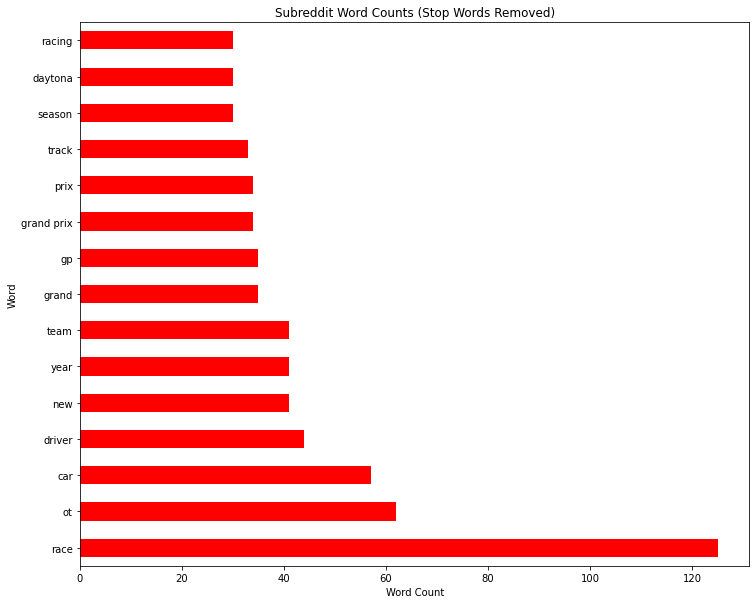

In [164]:
plt.figure(figsize=(12,10))
plt.title("Subreddit Word Counts (Stop Words Removed)")
plt.xlabel('Word Count')
plt.ylabel('Word')
X_df_3 = pd.DataFrame(X_cvec3.todense(), 
                          columns=cvec_3.get_feature_names())
X_df_3.sum().sort_values(ascending=False).head(15).plot(kind='barh', color = 'red');

Interpretation: We now have the most common words that may be useful for marketing formula 1 to nascar fans

Ultimatley by looking at subreddit word usage we should be able to determine the areas we can best market formula 1 to Nascar fans.

# Modeling

### Baseline model

In [159]:
df['subreddit'].value_counts(normalize=True)
# baseline model is 51% accuracy so models should perform better than this baseline

NASCAR      0.512675
formula1    0.487325
Name: subreddit, dtype: float64

### train/test splitting the data

In [98]:
# splitting the data up by train/test splitting 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## CVEC + MultinomialNB Modeling

In [92]:
# creating a pipline that count vectorizes text data and uses multinomialNB modeling
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words)),
    ('nb', MultinomialNB())
])

In [93]:
# creating pipe params for gridsearch
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000], # maximum number of words to include
    'cvec__min_df': [2, 3], # min occurance of words to use
    'cvec__max_df': [.9, .95], # max occurance of words to use
    'cvec__ngram_range': [(1,1), (1,2)] # 1 and 2 word combinations
}

In [94]:
# grid searching to find best cvec params
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [95]:
# fitting the grid search
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'albon',
                                                                              'alex',
                                                            

In [96]:
# gridsearch training accuracy
gs.score(X_train, y_train)

0.8980694980694981

In [100]:
# gridsearch testing accuracy 
gs.score(X_test, y_test)
# model is overfit

0.7695924764890282

## TVEC + MultinomialNB Model

In [102]:
# creating a pipeline for tvec and multinomialNB model
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words)),
    ('nb', MultinomialNB())
])

In [104]:
# setting up tvec pipe parameters for gridsearch
pipe_tvec_params = {
    'tvec__max_features': [1_000, 1_500, 2_000, 2_500, 3_000, 4_000],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_df': [1.0, .98, .75],
    'tvec__min_df': [1,2,5]  
}

In [105]:
# gridsearching for best tvec params
gs_tvec = GridSearchCV(pipe_tvec,
                        param_grid = pipe_tvec_params,
                        cv=5) # 5-fold cross-validation.

In [106]:
# fitting tvec nb model
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'albon',
                                                                              'alex',
                                                            

In [131]:
# tvec nb model training accuracy score
gs_tvec.score(X_train, y_train)

0.9694029850746269

In [109]:
# tvec nb model testing accuracy
gs_tvec.score(X_test, y_test)
# better model but still overfit

0.7789968652037618

## TVEC + RandomForestClassifier Modeling

In [110]:
# creating a pipeline for tvec and RandomForestClassifier model
pipe_rf_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words)), # stop words included for all models
    ('rf', RandomForestClassifier())
])

In [111]:
# setting up tvec pipe parameters for gridsearch
pipe_rf_tvec_params = {
    'rf__n_estimators': [100, 200, 300, 400],
    'rf__max_depth': [5, 6, 7, 10],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__min_df': [1,4,10],
    'tvec__max_features': [None, 200, 1000, 4000],
    'tvec__norm': ['l1', 'l2']
}

In [113]:
# gridsearching for best tvec params
gs_rf_tvec = GridSearchCV(pipe_rf_tvec,
                        param_grid = pipe_rf_tvec_params,
                        cv=5, n_jobs=6) # 5-fold cross-validation.

In [114]:
# fitting the tvec RandomForestClassifier model
gs_rf_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'albon',
                                                                              'alex',
                                                            

In [115]:
# tvec rf model training accuracy score
gs_rf_tvec.score(X_train, y_train)

0.7444015444015444

In [116]:
# tvec rf model testing accuracy score
gs_rf_tvec.score(X_test, y_test)
# model is only slightly overfit

0.7115987460815048

In [117]:
# getting the best model params
gs_rf_tvec.best_params_

{'rf__max_depth': 10,
 'rf__n_estimators': 200,
 'tvec__max_features': 4000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2'}

### final model using the params from the best RandomForestClassifier grid search

In [118]:
# creating, training and transforming tvec
tvec = TfidfVectorizer(stop_words=stop_words, max_features=4_000, ngram_range=(1,2), norm='l2')
tvec.fit(X_train)
X_train = tvec.transform(X_train)
X_test = tvec.transform(X_test)

In [119]:
# creating final RandomForestClassifier
rf_final = RandomForestClassifier(max_depth=10, n_estimators = 200)
rf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200)

In [120]:
# final model training accuracy score
rf_final.score(X_train, y_train)

0.7297297297297297

In [122]:
# final model testing accuracy score
rf_final.score(X_test, y_test)

0.7147335423197492

# Final Recommendations

In [124]:
# creating a dictionary of feature importance by feature name
feature_importance_dict = {}
for name, importance in zip(tvec.get_feature_names(), rf_final.feature_importances_):
    feature_importance_dict[name] = importance

In [125]:
# using feature_importance_dict to create a dataframe
feat_imp_df = pd.DataFrame(feature_importance_dict.values(), index=feature_importance_dict.keys(), columns=['importance'])

In [144]:
# looking at 100 most important features that determine subreddit
pd.set_option('display.max_rows', 100)
feat_imp_df.sort_values(by = 'importance', ascending = False).head(100)

,importance
gp,0.053524
grand,0.034840
grand prix,0.034658
ferrari,0.025630
red,0.024575
daytona,0.024146
prix,0.022137
williams,0.019982
fp2,0.018004
mercedes,0.015918


<BarContainer object of 15 artists>

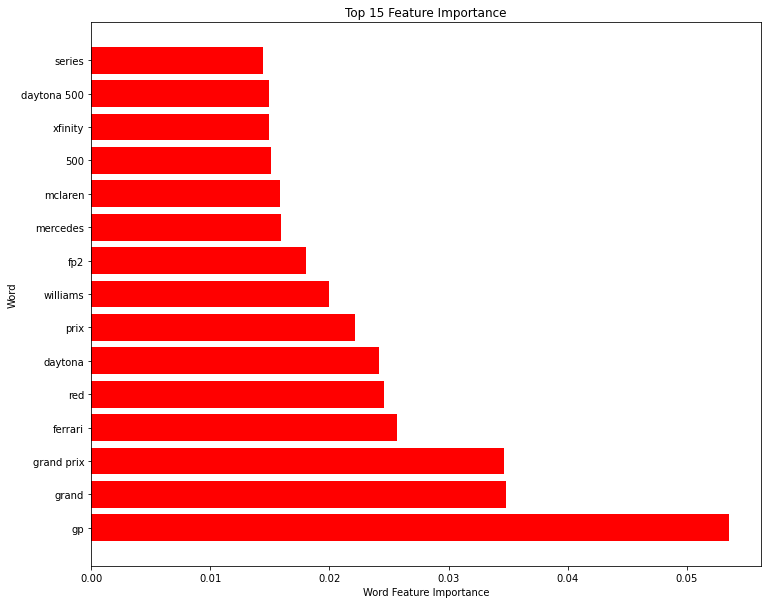

In [165]:
# finding the top 15 most important words
top_15=feat_imp_df.sort_values(by = 'importance', ascending = False).head(15)

# plotting the 15 most important words that determine subreddit
plt.figure(figsize=(12,10))
plt.title("Top 15 Feature Importance")
plt.xlabel('Word Feature Importance')
plt.ylabel('Word')
plt.barh(y = top_15.index, width = top_15['importance'],color="r", align="center")

Interpretation: In marketing towards Nascar viewers one of the key identifiable terms for Nascar over formula 1 is Daytona. This references the Daytona 500 in Florida. Given that Nascar viewers identify more strongly with the Daytona 500 over any other race it may be in formula 1’s best interest to begin marketing themselves at the Daytona 500 or even begin a new race, in Florida. There are current plans to begin a new Grand Prix in Florida in 2022, so this analysis confirms that this is likely a great strategy and could convert many Nascar fans to Formula 1.

In [146]:
# creating a dataframe of current Nascar manufactures
nascar_manuf = ['chevrolet','ford','toyota']
nascar_manu_imp = feat_imp_df.loc[nascar_manuf]
nascar_manu_imp

,importance
chevrolet,0.000000
ford,0.000674
toyota,0.000289


<BarContainer object of 3 artists>

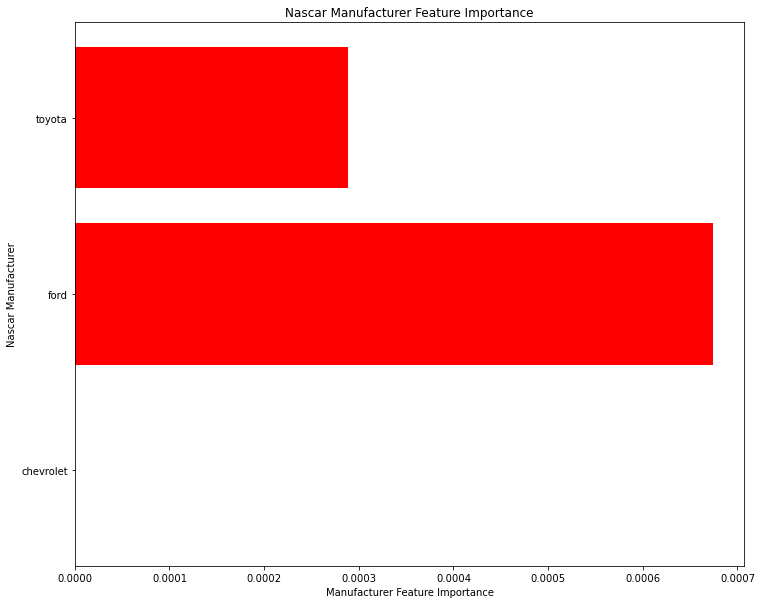

In [166]:
# plotting feature importance of current Nascar manufacturer
plt.figure(figsize=(12,10))
plt.title("Nascar Manufacturer Feature Importance")
plt.xlabel('Manufacturer Feature Importance')
plt.ylabel('Nascar Manufacturer')
plt.barh(y = nascar_manu_imp.index, width = nascar_manu_imp['importance'],color="r", align="center")

Interpretation: Of the three current Nascar manufactures, viewers identify with Ford the most. In attracting Nascar viewership,  Formula 1 may want to incentivize Ford coming to formula 1. In bringing ford to formula 1 perhaps loyal Nascar fans would follow suite. Ford also has the benefit of previously working with many Formula 1 teams building engines in the early 2000s. In converting Nascar fans to formula 1 we should focus on creating a new ford team over creating a new Chevrolet or Toyota team. 

In [150]:
# # creating a dataframe of current Nascar sponsors
other_insights = ['xfinity', 'coke','fox','sprint','monster']
nascar_other_imp = feat_imp_df.loc[other_insights]
nascar_other_imp

,importance
xfinity,0.014919
coke,0.000000
fox,0.002536
sprint,0.000559
monster,0.000619


<BarContainer object of 5 artists>

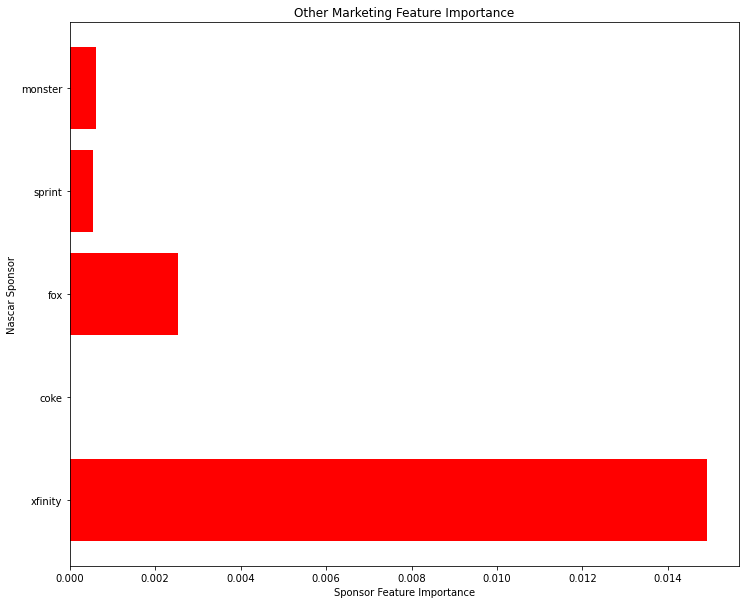

In [167]:
plt.figure(figsize=(12,10))
plt.title("Other Marketing Feature Importance")
plt.xlabel('Sponsor Feature Importance')
plt.ylabel('Nascar Sponsor')
plt.barh(y = nascar_other_imp.index, width = nascar_other_imp['importance'],color="r", align="center")

Interpretation: Nascar also tends to attract specific advertisements that connect with fans. Fans seem to especially notice the brands: monster, sprint, fox, coke and xfinity. Given these brands connections to Nascar it may be worthwhile continuing with further research to see how these brands market themselves to Nascar viewers. In understanding their brand strategy perhaps Formula 1 can adapt some of their methods and attract Nascar fans to formula 1 by similar methods. 